# PREPARE DATA

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt


def is_time_between(start_time, end_time, check_time):
    if start_time < end_time:
        return start_time <= check_time <= end_time
    else:  # crosses midnight
        return check_time >= start_time or check_time <= end_time

dataset_name = "GBP_USD_H1"
# Read the ohlcv data
# oanda_path = "/projects/genomic-ml/da2343/ml_project_2/data/gen_oanda_data"
oanda_path = "/Users/newuser/Projects/robust_algo_trader/data/gen_oanda_data"
df = pd.read_csv(f'{oanda_path}/{dataset_name}_processed_data.csv')
df = df.rename(columns={"time": "Time"})
df["Index"] = df.index
y = df[["Close"]]
offset = y.index[0]
df["Time"] = pd.to_datetime(df["Time"])
df['EMA_100'] = ta.EMA(df['Close'], timeperiod=100)
# drop na values
df = df.dropna()
# filter when time is only in 2016
# df = df[df["Time"] >= "2016-01-01 00:00:00"]


## STRATEGY ADAPTIVE PROFIT

In [ ]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []

for i, row in df.iterrows():
    current_time = row["Time"]
    condition_one = (
            (row["MACD_Crossover_Change"] > 0)
            and (row["Close"] > row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    condition_two = (
            (row["MACD_Crossover_Change"] < 0)
            and (row["Close"] < row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    if position == 0:
        if condition_one:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_two:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        else:
            stop_loss = max(stop_loss,  row['Close'] - atr_delta*row['ATR'])
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]
        else:
            stop_loss = min(stop_loss, row['Close'] + atr_delta*row['ATR'])

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df

In [ ]:
trades_df['Time'] = pd.to_datetime(trades_df['Time'])
trades_df['Year'] = trades_df['Time'].dt.year
trades_df['Month'] = trades_df['Time'].dt.month
sub_trades_df = trades_df[trades_df['Year'] == 2016].copy()
sub_trades_df = sub_trades_df[['Month', f'PnL']]
sub_trades_df = sub_trades_df.groupby(['Month']).agg({f'PnL': 'sum'}).reset_index()

# using the label column find the cumulative sum
sub_trades_df["cumulative_sum"] = sub_trades_df["PnL"].cumsum()
#plot first 100 trades
sub_trades_df["cumulative_sum"].plot()
# sub_trades_df

In [ ]:
# EUR_USD_H1 : off-years = 2014, 2016, 2021
# EUR_JPY_H1 : off-years = 2016
# GBP_JPY_H1 : off-years = 2023
# USD_MXN_H1 : off-years = 2018, 2019, 2022
# NZD_JPY_H1 : off-years = 2014, 2015, 2019

# AUD_HKD_H1 : off-years = 2015, 2018, 2019, 2021
# EUR_GBP_H1 : off-years = 2018, 2021, 2022, 2023

# ZAR_JPY_H1 : off-years = 2014, 2015, 2017, 2019
# USD_NOK_H1 : off-years = 2014, 2015
# USD_CHF_H1 : off-years = 2014
# TRY_JPY_H1 : off-years = 2014, 2019, 2021, 2022, 2023
# AUD_USD_H1 : off-years = 2015,2016,2018, 2019, 2022

In [ ]:
trades_df["PnL_label"].mean()

## STRATEGY FIXED PROFIT AND LOSS

In [ ]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []
atr_delta = 1.5
start_time = 13
end_time = 17

for i, row in df.iterrows():
    current_time = row["Time"]
    condition_buy = (
            (row["MACD_Crossover_Change"] > 0)
            and (row["Close"] > row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    condition_sell = (
            (row["MACD_Crossover_Change"] < 0)
            and (row["Close"] < row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    if position == 0:
        if condition_buy:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            take_profit = entry_price + atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_sell:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            take_profit = entry_price - atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        elif row['High'] > take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        else:
            pass
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]
        elif row['Low'] < take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]    
        else:
            pass

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df

In [ ]:
trades_df['Time'] = pd.to_datetime(trades_df['Time'])
trades_df['Year'] = trades_df['Time'].dt.year
trades_df['Month'] = trades_df['Time'].dt.month
sub_trades_df = trades_df[trades_df['Year'] == 2016].copy()
sub_trades_df = sub_trades_df[['Month', f'PnL']]
sub_trades_df = sub_trades_df.groupby(['Month']).agg({f'PnL': 'sum'}).reset_index()

# using the label column find the cumulative sum
sub_trades_df["cumulative_sum"] = sub_trades_df["PnL"].cumsum()
#plot first 100 trades
sub_trades_df["cumulative_sum"].plot()
# sub_trades_df

In [ ]:
# AUD_HKD_H1 : off-years = 2015, 2018
# EUR_GBP_H1: 2018, 2019, 2021


## STRATEGY FIXED PROFIT AND ADAPTIVE LOSS

In [ ]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []

for i, row in df.iterrows():
    current_time = row["Time"]
    condition_buy = (
            (row["MACD_Crossover_Change"] > 0)
            and (row["Close"] > row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    condition_sell = (
            (row["MACD_Crossover_Change"] < 0)
            and (row["Close"] < row["EMA_100"])
            and is_time_between(start_time, end_time, current_time.hour)
    )
    if position == 0:
        if condition_buy:
            position = 1
            entry_price = row['Close']
            stop_loss = entry_price - atr_delta*row['ATR']
            take_profit = entry_price + atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_sell:
            position = -1 
            entry_price = row['Close']
            stop_loss = entry_price + atr_delta*row['ATR']
            take_profit = entry_price - atr_delta*row['ATR']
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward, take_profit, stop_loss]
        elif row['High'] > take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward, take_profit, stop_loss]
        else:
            # stop loss must not be greater than the take profit
            # pass
            next_stop_loss = row['Close'] - atr_delta*row['ATR']
            if next_stop_loss < take_profit:
                stop_loss = max(stop_loss, next_stop_loss)
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward, take_profit, stop_loss]
        elif row['Low'] < take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward, take_profit, stop_loss] 
        else:
            # pass
            next_stop_loss = row['Close'] + atr_delta*row['ATR']
            if next_stop_loss > take_profit:
                stop_loss = min(stop_loss, next_stop_loss)

# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL', 'Take_Profit', 'Stop_Loss'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df

In [ ]:
trades_df["cumulative_sum"] = trades_df["PnL"].cumsum()
trades_df["cumulative_sum"].plot()

In [ ]:
trades_df['Time'] = pd.to_datetime(trades_df['Time'])
trades_df['Year'] = trades_df['Time'].dt.year
trades_df['Month'] = trades_df['Time'].dt.month
sub_trades_df = trades_df[trades_df['Year'] == 2014].copy()
sub_trades_df = sub_trades_df[['Month', f'PnL']]
sub_trades_df = sub_trades_df.groupby(['Month']).agg({f'PnL': 'sum'}).reset_index()
sub_trades_df["cumulative_sum"] = sub_trades_df["PnL"].cumsum()
sub_trades_df["cumulative_sum"].plot()

In [ ]:
x = 642
y = 599

p = (x) / (x+y)
p * 100

In [ ]:
df

## OPENING RANGE BREAKOUT STRATEGY

In [26]:
# Initialize the variables for position, entry price and stop loss
position = 0
entry_price = 0
stop_loss = 0
trades = []


atr_delta = 3
start_time = 8
end_time = 17

range_start_time = 5
range_end_time = 8

for i, row in df.iterrows():
    current_time = row["Time"]
    latest_trade_date = trades[-1][1].date() if trades else None
    current_date = current_time.date()

    if (
        position == 0
        and is_time_between(start_time, end_time, current_time.hour)
        and current_date != latest_trade_date
    ):
        # range_df should be from range_start_time to range_end_time
        range_df = df[
            (df["Time"].dt.hour >= range_start_time)
            & (df["Time"].dt.hour <= range_end_time)
            & (df["Time"].dt.date == current_date)
        ]

        if range_df.empty:
            continue

        opening_high = range_df["High"].max()
        opening_low = range_df["Low"].min()
        opening_range = opening_high - opening_low
        
        if opening_range < row["ATR"]:
            continue

        condition_buy = (row["Close"] > opening_high)
        condition_sell = (row["Close"] < opening_low)

        if condition_buy:
            position = 1
            entry_price = row['Close']
            # stop_loss = entry_price - atr_delta*row['ATR']
            # take_profit = entry_price + atr_delta*row['ATR']

            take_profit = entry_price + opening_range
            stop_loss = entry_price - 0.5*opening_range
            init_stop_loss = stop_loss
            trades.append(['Buy', current_time, entry_price, 0])
        elif condition_sell:
            position = -1 
            entry_price = row['Close']
            # stop_loss = entry_price + atr_delta*row['ATR']
            # take_profit = entry_price - atr_delta*row['ATR']
            
            stop_loss = entry_price + 0.5*opening_range
            take_profit = entry_price - opening_range
            init_stop_loss = stop_loss
            trades.append(['Sell', current_time, entry_price, 0])
    elif position == 1:
        if row['Low'] < stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        elif row['High'] > take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (exit_price - entry_price) 
            target_loss = (entry_price - init_stop_loss)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Buy', current_time, exit_price, risk_reward]
        else:
            pass
    elif position == -1:
        if row['High'] > stop_loss:
            position = 0
            exit_price = stop_loss
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]
        elif row['Low'] < take_profit:
            position = 0
            exit_price = take_profit
            target_profit = (entry_price - exit_price)
            target_loss = (init_stop_loss - entry_price)
            risk_reward = (target_profit/target_loss)
            trades[-1] = ['Sell', current_time, exit_price, risk_reward]    
        else:
            pass


In [27]:
# Convert the list of trades to a dataframe
trades_df = pd.DataFrame(trades, columns=['Action', 'Time', 'Price', 'PnL'])

# Print the trades
# Add the PnL_label column where 1 is a positive or breakeven return and 0 is a negative return
trades_df['PnL_label'] = np.where(trades_df['PnL'] >= 0, 1, 0)
trades_df["PnL_label"].mean() 

0.3320388349514563

<Axes: >

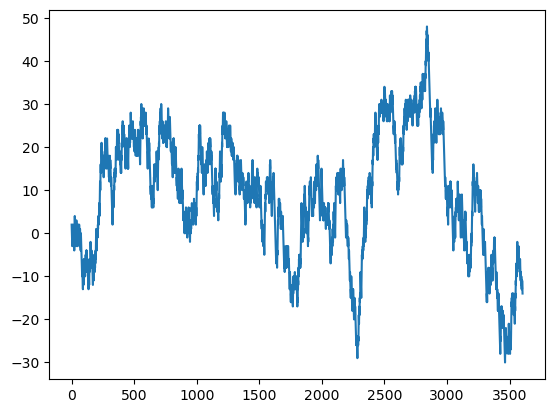

In [28]:
trades_df["cumulative_sum"] = trades_df["PnL"].cumsum()
trades_df["cumulative_sum"].plot()

In [29]:
trades_df

,Action,Time,Price,PnL,PnL_label,cumulative_sum
0,Sell,2005-01-04 12:00:00+00:00,1.892400,2.0,1,2.000000e+00
1,Sell,2005-01-05 11:00:00+00:00,1.879175,-1.0,0,1.000000e+00
2,Sell,2005-01-06 14:00:00+00:00,1.876550,-1.0,0,-4.130030e-14
3,Buy,2005-01-07 11:00:00+00:00,1.879450,-1.0,0,-1.000000e+00
4,Buy,2005-01-10 11:00:00+00:00,1.875525,-1.0,0,-2.000000e+00
...,...,...,...,...,...,...
3600,Sell,2023-12-18 10:00:00+00:00,1.267695,-1.0,0,-1.300000e+01
3601,Buy,2023-12-19 12:00:00+00:00,1.273080,2.0,1,-1.100000e+01
3602,Sell,2023-12-20 14:00:00+00:00,1.267705,-1.0,0,-1.200000e+01
3603,Buy,2023-12-21 13:00:00+00:00,1.264900,-1.0,0,-1.300000e+01
